<a href="https://colab.research.google.com/github/Rohit-Madhesiya/LangGraph-Implementations/blob/main/LangGraph_Chatbot_with_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install langgraph langsmith langchain_groq langchain_community arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.7 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=4cfd5eb208f5af009e974405c7969b0e00f97a16369d957260d87bbb65c84467
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=93a06df0f478511fa5d4085bcb5a49d50ee795f060df098e2f688a71c09f9888
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built wikipedia sgmllib3k


In [2]:
from typing import Annotated
from typing_extensions import TypedDict

Working with External Tools

In [6]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

# Arxiv and Wikipedia Tools
arxiv_api_wrapper=ArxivAPIWrapper(
    top_k_results=1,
    doc_content_chars_max=300
)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_api_wrapper)

wiki_api_wrapper=WikipediaAPIWrapper(
    top_k_results=1,
    doc_content_chars_max=300
)

wiki_tool=WikipediaQueryRun(api_wrapper=wiki_api_wrapper)

In [9]:
wiki_tool.invoke("Who is Virat Kohli?")

'Page: Virat Kohli\nSummary: Virat Kohli (born 5 November 1988) is an Indian international cricketer who plays Test and ODI cricket for the national team and is a former captain in all formats. He is a right-handed batsman and an occasional right arm medium pace bowler. He is called the king and the c'

In [10]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [11]:
tools=[wiki_tool,arxiv_tool]

**LangGraph Application**

In [14]:
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [15]:
from langgraph.graph import StateGraph,START,END

graph_builder=StateGraph(State)
graph_builder

In [17]:
from google.colab import userdata
from langchain_groq import ChatGroq

llm=ChatGroq(
    groq_api_key=userdata.get("GROQ_API_KEY"),
    model_name="gemma2-9b-it"
    )
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x79f61e6d2250>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x79f61e6d34d0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [18]:
llm_with_tools=llm.bind_tools(tools=tools)

In [19]:
def chatbot(state:State):
  return {
      "messages":[llm_with_tools.invoke(state['messages'])]
  }

For adding tools into the langgraph needs this

In [20]:
from langgraph.prebuilt import ToolNode,tools_condition

In [21]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [22]:
graph=graph_builder.compile()

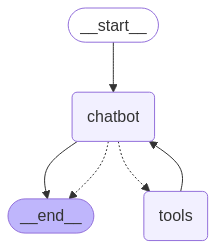

In [23]:
graph

In [26]:
user_input="Hey, My name is Rohit"
events=graph.stream(
    {'messages': [("user",user_input)]},
    stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hey, My name is Rohit
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_ermv)
 Call ID: call_ermv
  Args:
    query: Rohit
================================= Tool Message =================================
Name: wikipedia

Page: Rohit Sharma
Summary: Rohit Sharma (born 30 April 1987) is an Indian cricketer and the captain of national cricket team in Test and ODI formats. He is widely regarded as one of the greatest opening batters of all time. He is also known as one of the greatest six hitters in cricket history. He 
================================== Ai Message ==================================

Hi Rohit, nice to meet you!  Do you play cricket?


In [27]:
user_input="Who is Virat Kohli?"
events=graph.stream(
    {'messages': [("user",user_input)]},
    stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is Virat Kohli?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_3e23)
 Call ID: call_3e23
  Args:
    query: Virat Kohli
================================= Tool Message =================================
Name: wikipedia

Page: Virat Kohli
Summary: Virat Kohli (born 5 November 1988) is an Indian international cricketer who plays Test and ODI cricket for the national team and is a former captain in all formats. He is a right-handed batsman and an occasional right arm medium pace bowler. He is called the king and the c
================================== Ai Message ==================================

Virat Kohli is an Indian international cricketer who plays Test and ODI cricket for the national team and is a former captain in all formats. He is a right-handed batsman and an occasional right arm medium pace bowler.


In [28]:
user_input="Revisiting Word Embeddings in the LLM"
events=graph.stream(
    {'messages': [("user",user_input)]},
    stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Revisiting Word Embeddings in the LLM
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_8qer)
 Call ID: call_8qer
  Args:
    query: Word embeddings in large language models
================================= Tool Message =================================
Name: wikipedia

Page: Word embedding
Summary: In natural language processing, a word embedding is a representation of a word. The embedding is used in text analysis. Typically, the representation is a real-valued vector that encodes the meaning of the word in such a way that the words that are closer in the vector 
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_hhj9)
 Call ID: call_hhj9
  Args:
    query: Word embeddings
================================= Tool Message =================================
Name: wikipedia

Page: Word emb

In [29]:
user_input="2502.19607"
events=graph.stream(
    {'messages': [("user",user_input)]},
    stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

2502.19607
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_4mpj)
 Call ID: call_4mpj
  Args:
    query: 2502.19607
================================= Tool Message =================================
Name: arxiv

Published: 2025-02-26
Title: Revisiting Word Embeddings in the LLM Era
Authors: Yash Mahajan, Matthew Freestone, Sathyanarayanan Aakur, Santu Karmaker
Summary: Large Language Models (LLMs) have recently shown remarkable advancement in
various NLP tasks. As such, a popular trend has emerged lately wh
================================== Ai Message ==================================

Can you tell me more about what Large Language Models are and how they are used?
